In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('input/train_post_competition.csv')
df.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [3]:
from IPython.display import Audio
file = '786ee883.wav'
path = 'input/audio_train/'
Audio(filename=path+file)

In [4]:
# Vamos a definir una funcion para extraer la duracion de un audio en segundos
import wave

def get_length(file):
    audio = wave.open(path+file)
    return audio.getnframes() / audio.getframerate()

get_length(file)

3.7

In [5]:
# Vamos a procesar en paralelo la funcion en todos los archivos
from joblib import Parallel, delayed

with Parallel(n_jobs=10, prefer='threads', verbose=1) as ex:
    lengths = ex(delayed(get_length)(e) for e in df.fname)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 9473 out of 9473 | elapsed:    2.5s finished


In [6]:
df['length'] = lengths
df.head()

,fname,label,manually_verified,freesound_id,license,length
0,00044347.wav,Hi-hat,0,28739,Attribution,14.00
1,001ca53d.wav,Saxophone,1,358827,Attribution,10.32
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0,0.44
3,0033e230.wav,Glockenspiel,1,325017,Attribution,8.00
4,00353774.wav,Cello,1,195688,Attribution,4.52


In [7]:
df = df.query('length <= 6').reset_index(drop=True)
print(df.shape)
df.head()

(5843, 6)


,fname,label,manually_verified,freesound_id,license,length
0,002d256b.wav,Trumpet,0,10897,Creative Commons 0,0.44
1,00353774.wav,Cello,1,195688,Attribution,4.52
2,003da8e5.wav,Knock,1,164564,Creative Commons 0,1.36
3,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0,1.04
4,006f2f32.wav,Hi-hat,1,138726,Attribution,1.68


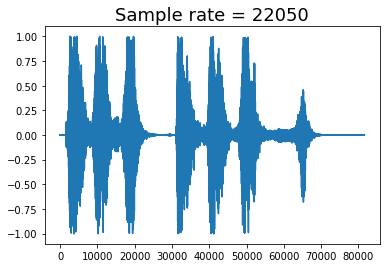

In [8]:
import librosa

y, sr = librosa.load(path+file)
# y : audio data
# sr: sample rate

plt.plot(y)
plt.title(f'Sample rate = {sr}', size=18);

(40, 160)


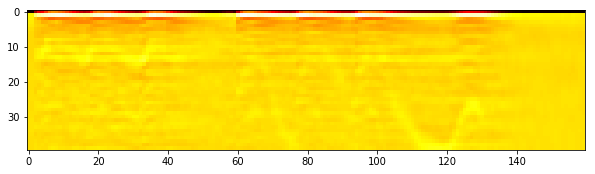

In [9]:
mfcc = librosa.feature.mfcc(y, sr, n_mfcc=40)
print(mfcc.shape)

plt.figure(figsize=(10,5))
plt.imshow(mfcc, cmap='hot');

In [10]:
def obtain_mfcc(file, features=40):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    return librosa.feature.mfcc(y, sr, n_mfcc=features)

In [11]:
obtain_mfcc(file).shape

(40, 160)

In [12]:
mfcc.shape

(40, 160)

In [13]:
def get_mfcc(file, n_mfcc=40, padding=None):
    y, sr = librosa.load(path+file, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=n_mfcc)
    if padding: mfcc = np.pad(mfcc, ((0, 0), (0, max(0, padding-mfcc.shape[1]))), 'constant')
    return mfcc.astype(np.float32)



(40, 200)


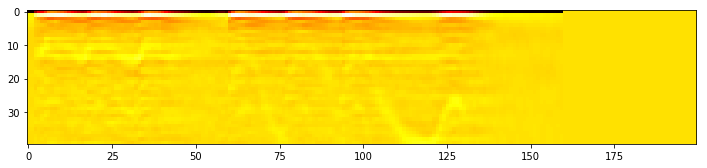

In [14]:
mfcc = get_mfcc(file, padding=200)
print(mfcc.shape)
plt.figure(figsize=(12,5))
plt.imshow(mfcc, cmap='hot');

In [15]:
print(get_mfcc(df.sort_values('length').fname.iloc[-1]).shape)

(40, 259)


In [16]:
from functools import partial

n_mfcc = 40
padding = 259
fun = partial(get_mfcc, n_mfcc=n_mfcc, padding=padding)

with Parallel(n_jobs=10, prefer='threads', verbose=1) as ex:
    mfcc_data = ex(delayed(partial(fun))(e) for e in df.fname)
    
# Juntamos la data en un solo array y agregamos una dimension
mfcc_data = np.stack(mfcc_data)[..., None]
mfcc_data.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   32.5s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   46.9s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 5843 out of 5843 | elapsed:  2.6min finished


(5843, 40, 259, 1)

In [17]:
lbl2idx = {lbl:idx for idx,lbl in enumerate(df.label.unique())}
idx2lbl = {idx:lbl for lbl,idx in lbl2idx.items()}
n_categories = len(lbl2idx)

In [18]:
lbl2idx

{'Trumpet': 0,
 'Cello': 1,
 'Knock': 2,
 'Gunshot_or_gunfire': 3,
 'Hi-hat': 4,
 'Snare_drum': 5,
 'Writing': 6,
 'Laughter': 7,
 'Fart': 8,
 'Oboe': 9,
 'Cough': 10,
 'Flute': 11,
 'Bass_drum': 12,
 'Clarinet': 13,
 'Microwave_oven': 14,
 'Burping_or_eructation': 15,
 'Harmonica': 16,
 'Double_bass': 17,
 'Shatter': 18,
 'Fireworks': 19,
 'Bark': 20,
 'Tambourine': 21,
 'Telephone': 22,
 'Keys_jangling': 23,
 'Bus': 24,
 'Cowbell': 25,
 'Meow': 26,
 'Drawer_open_or_close': 27,
 'Squeak': 28,
 'Glockenspiel': 29,
 'Tearing': 30,
 'Violin_or_fiddle': 31,
 'Finger_snapping': 32,
 'Acoustic_guitar': 33,
 'Electric_piano': 34,
 'Saxophone': 35,
 'Scissors': 36,
 'Gong': 37,
 'Computer_keyboard': 38,
 'Chime': 39,
 'Applause': 40}

In [19]:
idx2lbl

{0: 'Trumpet',
 1: 'Cello',
 2: 'Knock',
 3: 'Gunshot_or_gunfire',
 4: 'Hi-hat',
 5: 'Snare_drum',
 6: 'Writing',
 7: 'Laughter',
 8: 'Fart',
 9: 'Oboe',
 10: 'Cough',
 11: 'Flute',
 12: 'Bass_drum',
 13: 'Clarinet',
 14: 'Microwave_oven',
 15: 'Burping_or_eructation',
 16: 'Harmonica',
 17: 'Double_bass',
 18: 'Shatter',
 19: 'Fireworks',
 20: 'Bark',
 21: 'Tambourine',
 22: 'Telephone',
 23: 'Keys_jangling',
 24: 'Bus',
 25: 'Cowbell',
 26: 'Meow',
 27: 'Drawer_open_or_close',
 28: 'Squeak',
 29: 'Glockenspiel',
 30: 'Tearing',
 31: 'Violin_or_fiddle',
 32: 'Finger_snapping',
 33: 'Acoustic_guitar',
 34: 'Electric_piano',
 35: 'Saxophone',
 36: 'Scissors',
 37: 'Gong',
 38: 'Computer_keyboard',
 39: 'Chime',
 40: 'Applause'}

In [18]:
n_categories = len(lbl2idx)

In [19]:
df['y'] = df.label.map(lbl2idx)
df.head()

,fname,label,manually_verified,freesound_id,license,length,y
0,002d256b.wav,Trumpet,0,10897,Creative Commons 0,0.44,0
1,00353774.wav,Cello,1,195688,Attribution,4.52,1
2,003da8e5.wav,Knock,1,164564,Creative Commons 0,1.36,2
3,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0,1.04,3
4,006f2f32.wav,Hi-hat,1,138726,Attribution,1.68,4


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(mfcc_data, df.y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((4674, 40, 259, 1), (1169, 40, 259, 1))

In [21]:
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Input, GlobalAvgPool2D, GlobalMaxPool2D, concatenate
from keras.optimizers import Adam, SGD
import keras.backend as K

Using TensorFlow backend.


In [22]:
bs = 128
lr = 0.003

m_in = Input([n_mfcc, padding, 1])
x = BatchNormalization()(m_in)

layers = [10, 20, 50, 100]
for i,l in enumerate(layers):
    strides = 1 if i == 0 else (2,2)
    x = Conv2D(l, 3, strides=strides, activation='relu', padding='same',
               use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

x_avg = GlobalAvgPool2D()(x)
x_max = GlobalMaxPool2D()(x)

x = concatenate([x_avg, x_max])
x = Dense(1000, activation='relu', use_bias=False, kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
m_out = Dense(n_categories, activation='softmax')(x)

model = Model(m_in, m_out)
model.compile(Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 259, 1)   0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 259, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 259, 10)  90          batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2

In [24]:
log1 = model.fit(x_train, y_train, bs, 15, validation_data=[x_val, y_val])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 4674 samples, validate on 1169 samples
Epoch 1/15
4674/4674 [==============================] - 8s 2ms/step - loss: 6.8114 - acc: 0.1699 - val_loss: 11.9706 - val_acc: 0.0659
Epoch 2/15
4674/4674 [==============================] - 4s 823us/step - loss: 2.5155 - acc: 0.3395 - val_loss: 2.3801 - val_acc: 0.3704
Epoch 3/15
4674/4674 [==============================] - 4s 832us/step - loss: 1.8716 - acc: 0.4730 - val_loss: 2.0728 - val_acc: 0.4500
Epoch 4/15
4674/4674 [==============================] - 4s 831us/step - loss: 1.5982 - acc: 0.5439 - val_loss: 1.8540 - val_acc: 0.5098
Epoch 5/15
4674/4674 [==============================] - 4s 827us/step - loss: 1.3804 - acc: 0.5988 - val_loss: 1.4917 - val_acc: 0.5877
Epoch 6/15
4674/4674 [==============================] - 4s 826us/step - loss: 1.2429 - acc: 0.6331 - val_loss: 1.5271 - val_acc: 0.5697
Epoch 7/15


In [25]:
K.eval(model.optimizer.lr.assign(lr/10))
log2 = model.fit(x_train, y_train, bs, 10, validation_data=[x_val, y_val])

Train on 4674 samples, validate on 1169 samples
Epoch 1/10
4674/4674 [==============================] - 4s 858us/step - loss: 0.3430 - acc: 0.8900 - val_loss: 1.1078 - val_acc: 0.7357
Epoch 2/10
4674/4674 [==============================] - 4s 839us/step - loss: 0.2737 - acc: 0.9187 - val_loss: 1.0980 - val_acc: 0.7408
Epoch 3/10
4674/4674 [==============================] - 4s 831us/step - loss: 0.2239 - acc: 0.9328 - val_loss: 1.1009 - val_acc: 0.7476
Epoch 4/10
4674/4674 [==============================] - 4s 841us/step - loss: 0.2078 - acc: 0.9375 - val_loss: 1.0988 - val_acc: 0.7425
Epoch 5/10
4674/4674 [==============================] - 4s 829us/step - loss: 0.1936 - acc: 0.9418 - val_loss: 1.1096 - val_acc: 0.7468
Epoch 6/10
4674/4674 [==============================] - 4s 831us/step - loss: 0.1832 - acc: 0.9463 - val_loss: 1.1070 - val_acc: 0.7519
Epoch 7/10
4674/4674 [==============================] - 4s 831us/step - loss: 0.1857 - acc: 0.9429 - val_loss: 1.1121 - val_acc: 0.7425


In [26]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
        trn_acc += log.history['acc']
        val_acc += log.history['val_acc']
    
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(trn_loss, label='train')
    ax1.plot(val_loss, label='validation')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(trn_acc, label='train')
    ax2.plot(val_acc, label='validation')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax,title in zip(axes, ['Train', 'Accuracy']):
        ax.set_title(title, size=14)
        ax.legend()

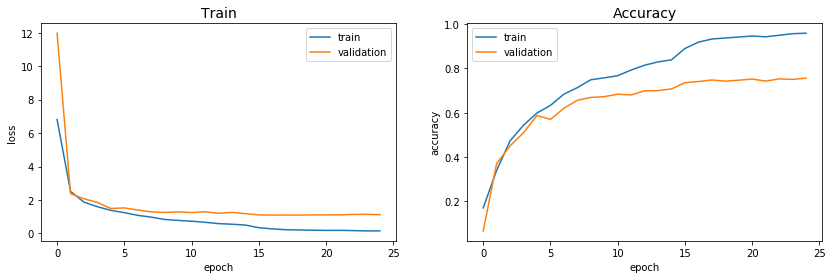

In [27]:
show_results(log1, log2)

In [52]:
sample = df.sample()
sample_file = sample.fname.iloc[0]
sample_label = sample.label.iloc[0]

mfcc = get_mfcc(sample_file, n_mfcc, padding)[None, ..., None]
y_ = model.predict(mfcc)
pred = idx2lbl[np.argmax(y_)]


print(f'True       = {sample_label}')
print(f'Prediction = {pred}')
Audio(path + sample_file)

[[5.3547992e-05 1.9658986e-05 1.3638535e-04 2.6887821e-07 1.8852747e-07
  4.4443741e-06 5.7046371e-08 5.2062329e-04 3.0510303e-06 5.2431483e-06
  6.7268492e-04 8.9007855e-04 8.0311412e-07 1.5154304e-03 1.3420150e-04
  2.0899927e-06 2.5269819e-06 1.4448453e-07 7.6581777e-08 1.8681780e-08
  9.6354079e-06 4.3117403e-08 7.2754906e-06 6.6983226e-08 2.3558610e-07
  1.4692054e-06 6.8253865e-03 3.0765759e-06 9.8841572e-01 1.0981645e-10
  1.9655583e-06 6.6710607e-05 5.3445259e-08 3.6694630e-07 4.0281724e-05
  5.8641795e-06 3.7888950e-09 6.5964821e-04 1.2962766e-09 6.9859925e-07
  1.6890848e-08]]
True       = Squeak
Prediction = Squeak


In [55]:
def get_mfcc2(file, n_mfcc=40, padding=None):
    y, sr = librosa.load(file, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y, sr, n_mfcc=n_mfcc)
    if padding: mfcc = np.pad(mfcc, ((0, 0), (0, max(0, padding-mfcc.shape[1]))), 'constant')
    return mfcc.astype(np.float32)

In [57]:
mfcc = get_mfcc2("test_audio.wav", n_mfcc, padding)[None, ..., None]
y_ = model.predict(mfcc)
pred = idx2lbl[np.argmax(y_)]
print(pred)

Cough


In [54]:
model.save('best_model.h5')

In [4]:
from keras.models import load_model
model = load_model('best_model.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
import librosa
n_mfcc = 40
padding = 259
mfcc = get_mfcc("047b3d34.wav", n_mfcc, padding)[None, ..., None]
y_ = model.predict(mfcc)
pred = idx2lbl[np.argmax(y_)]
print(pred)

NameError: name 'get_mfcc' is not defined